## Build features for modeling

### Load data


In [20]:
from activity_tracker import utils
import sqlite3
import pandas as pd
import pathlib
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Data loading
data_dir = pathlib.Path("../data")
db_path = data_dir / "sqlite" / "analysis.db"
mapper_path = data_dir / "data_mapper.yml"
conn = sqlite3.connect(db_path)
mapping_dict = utils.load_data_mapper(mapper_path)

df_subject = pd.read_sql_query("SELECT * FROM subject", conn)
df_visit = pd.read_sql_query("SELECT * FROM visit", conn)
df_measurement = pd.read_sql_query("SELECT * FROM daily_measurement", conn)

# Add ffp status binary
df_visit["ffp_status"] = df_visit["ffp_status"].astype(float).map(mapping_dict["ffp_status"])
df_visit['ffp_status'] = df_visit['ffp_status'].replace({'prefrail': 'no_frail', 'robust': 'no_frail'})
# Elimination of columns with too many missing values
drop_cols = [
    'floors', 'resting_heart_rate', 'average_sp_o2', 'min_sp_o2', 'max_sp_o2'
]
df_measurement = df_measurement.drop(columns=drop_cols)

In [38]:
# # store each to csv
# df_subject.to_csv("../data/train/subject.csv", index=False)
# df_visit.to_csv("../data/train/visit.csv", index=False)
# df_measurement.to_csv("../data/train/daily_measurement.csv", index=False)

### Build features



In [21]:
# Add prev visit date and ffp status binary
df_visit.sort_values(["subject_id", "visit_id"])
df_visit["prev_visit_date"] = df_visit.groupby("subject_id")["date"].shift(1)
df_visit["prev_ffp_status"] = df_visit.groupby("subject_id")["ffp_status"].shift(1)
df_visit['date'] = pd.to_datetime(df_visit['date'])
df_visit['days_since_prev_visit'] = df_visit.groupby('subject_id')['date'].diff().dt.days

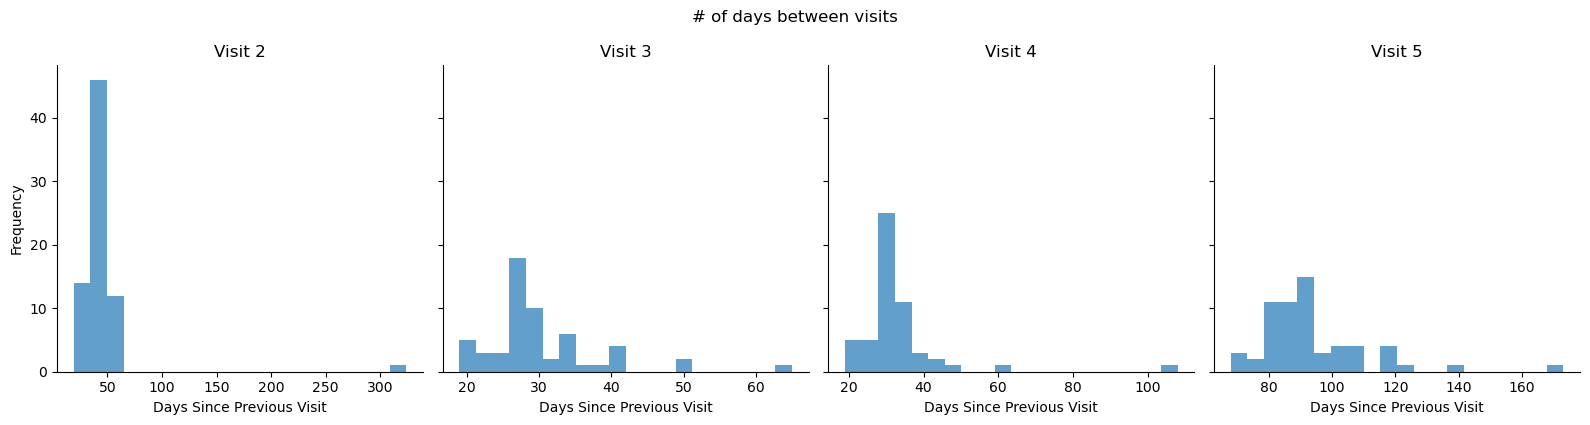

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

visit_ids = sorted([v for v in df_visit['visit_id'].unique() if v != 1])
n_visits = len(visit_ids)

fig, axes = plt.subplots(1, n_visits, figsize=(4 * n_visits, 4), sharey=True)

for i, visit_id in enumerate(visit_ids):
    ax = axes[i]
    group = df_visit[df_visit['visit_id'] == visit_id]
    ax.hist(group['days_since_prev_visit'].dropna(), bins=20, alpha=0.7)
    ax.set_title(f'Visit {visit_id}')
    ax.set_xlabel('Days Since Previous Visit')
    sns.despine(ax=ax)
    if i == 0:
        ax.set_ylabel('Frequency')

plt.tight_layout()
plt.suptitle('# of days between visits', y=1.05)
plt.show()

In [11]:
# Prepare visit dates for each subject
df_visit['date'] = pd.to_datetime(df_visit['date'])
df_measurement['date'] = pd.to_datetime(df_measurement['date'])

visit_dates = df_visit[['subject_id', 'date', 'visit_id']].copy()

# Function to compute days since last visit for each measurement
def get_days_since_last_visit(row):
    subject_visits = visit_dates[visit_dates['subject_id'] == row['subject_id']]
    past_visits = subject_visits[subject_visits['date'] <= row['date']]
    if past_visits.empty:
        return None
    last_visit_date = past_visits['date'].max()
    return (row['date'] - last_visit_date).days

df_measurement['days_since_last_visit'] = df_measurement.apply(get_days_since_last_visit, axis=1)

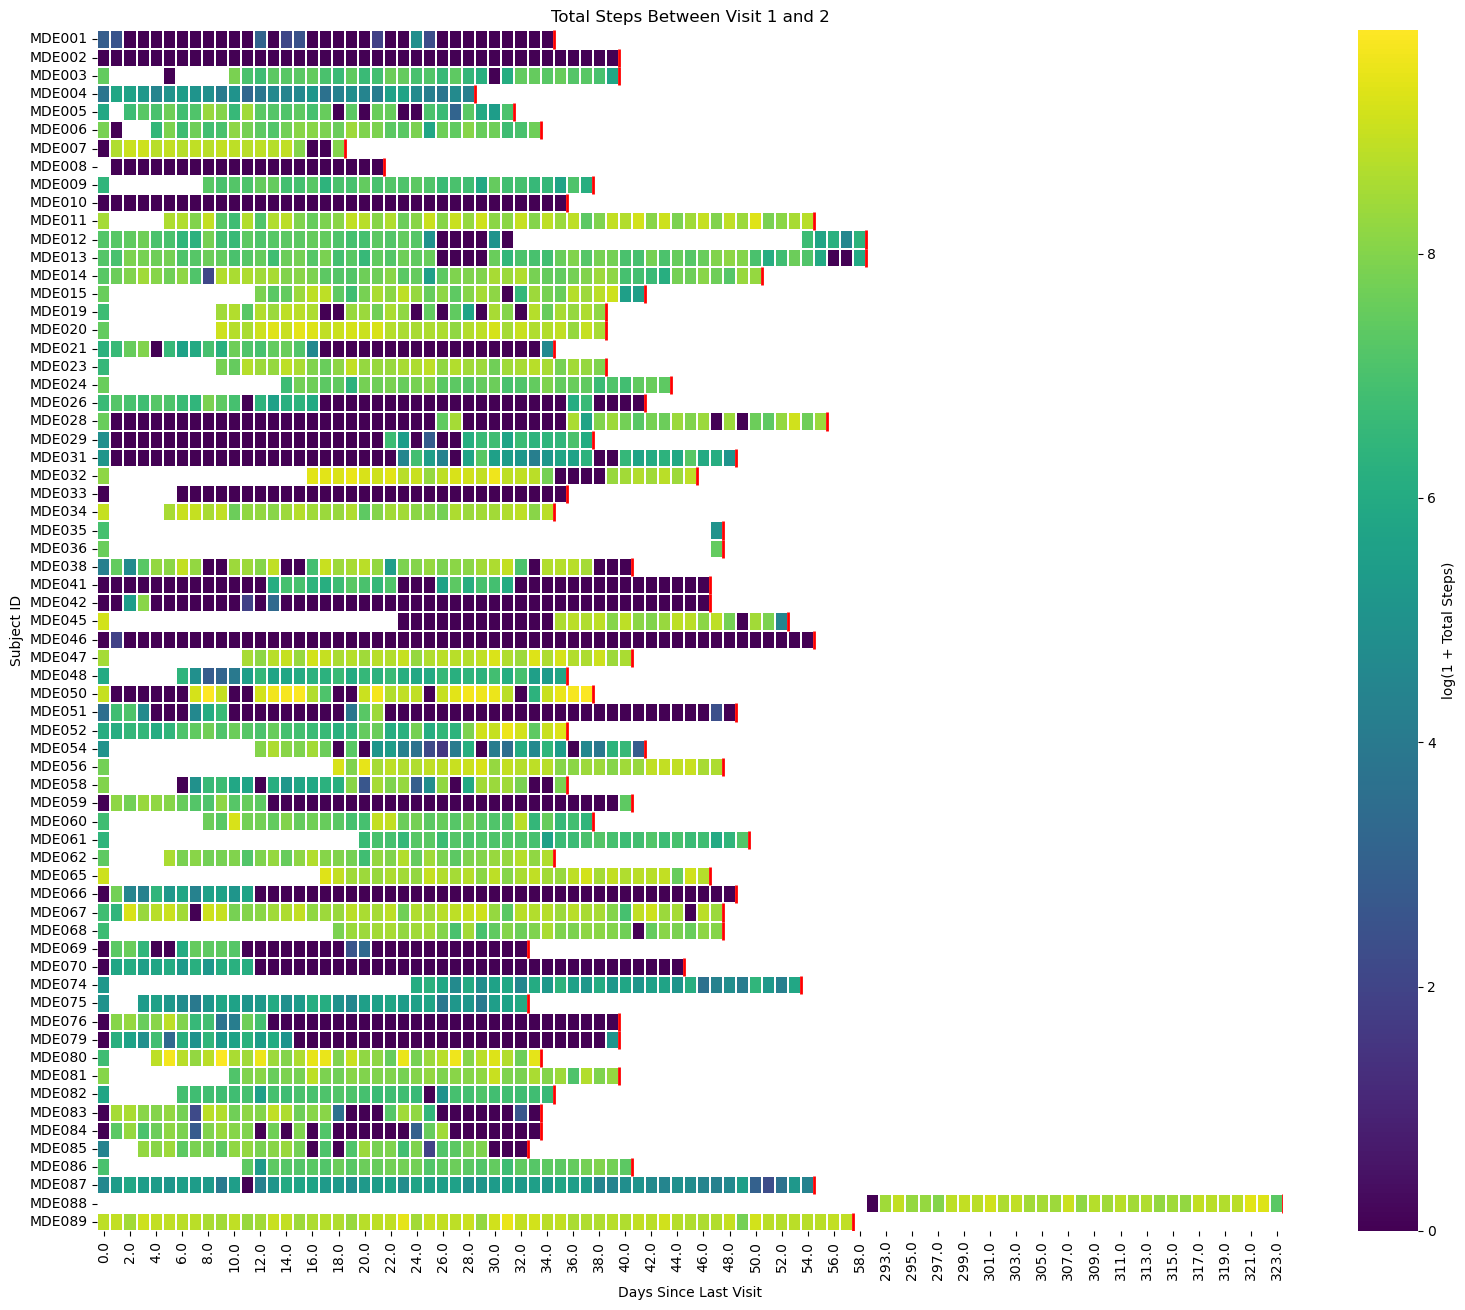

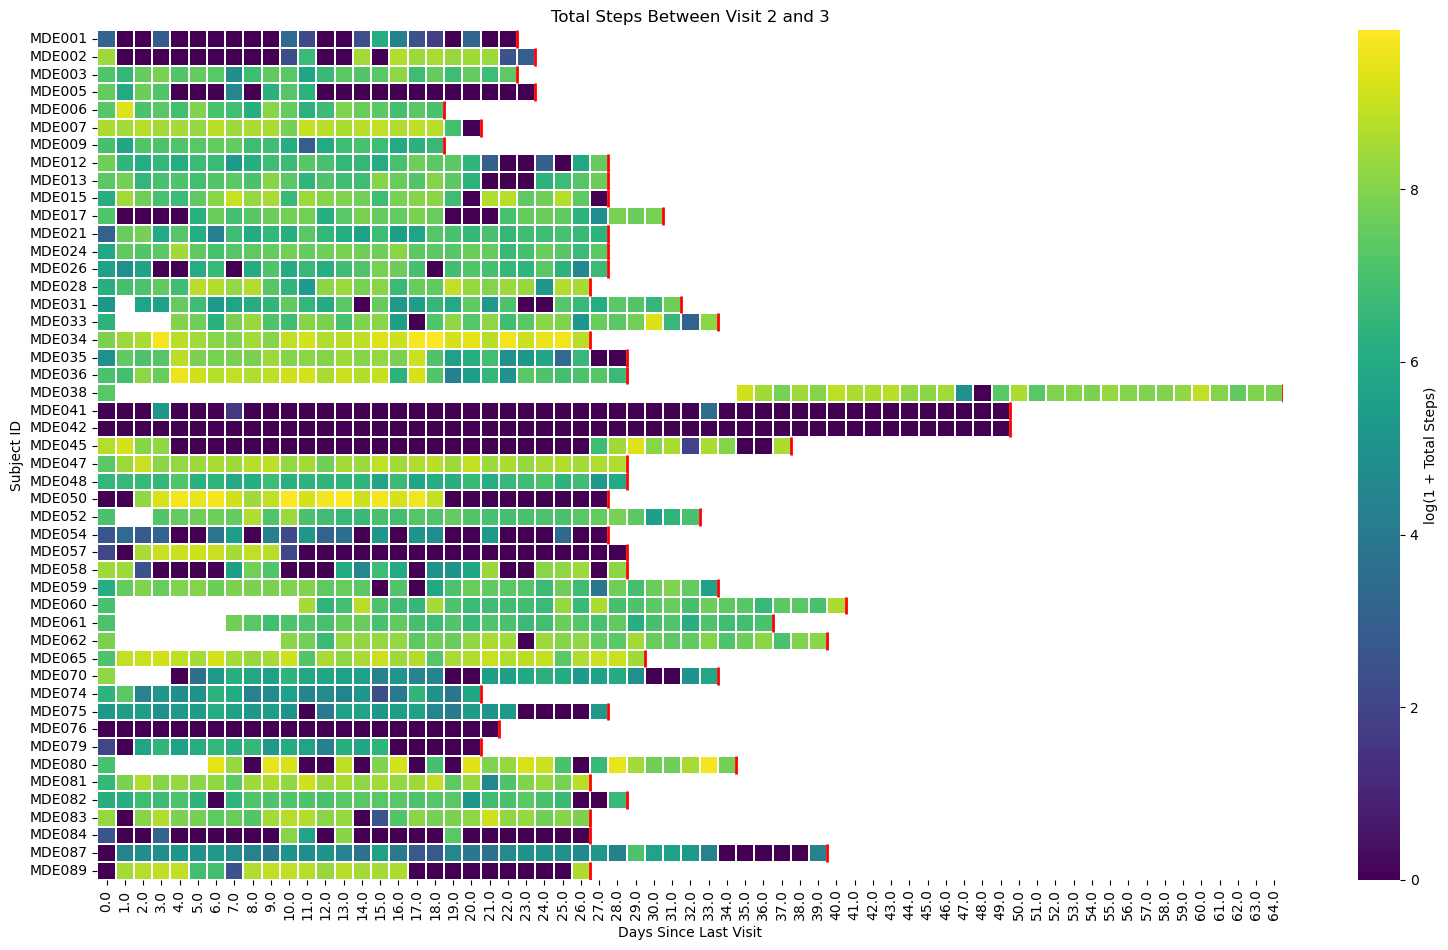

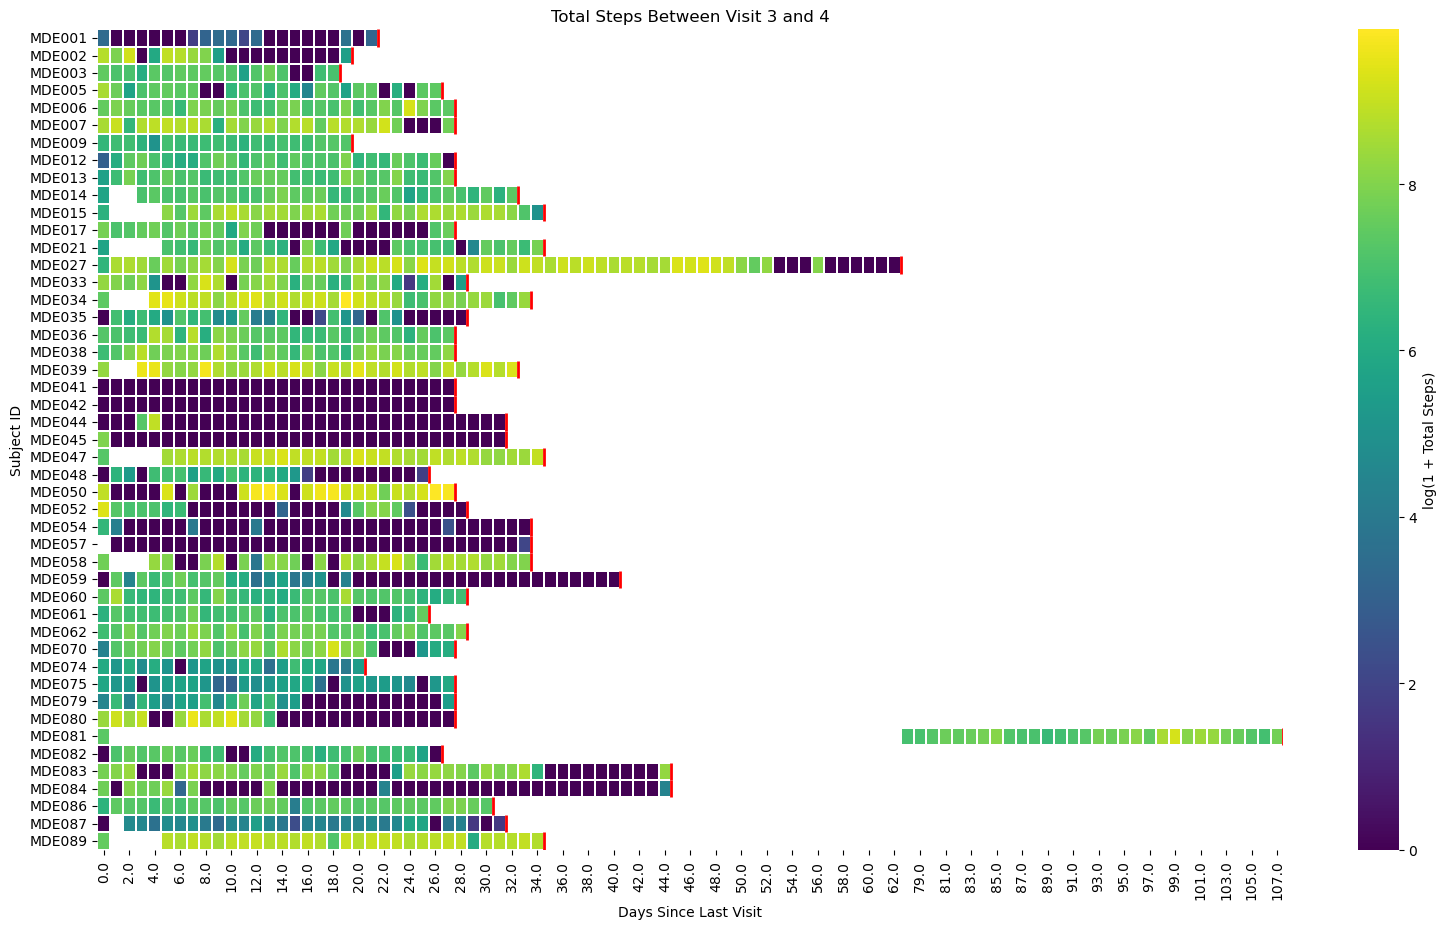

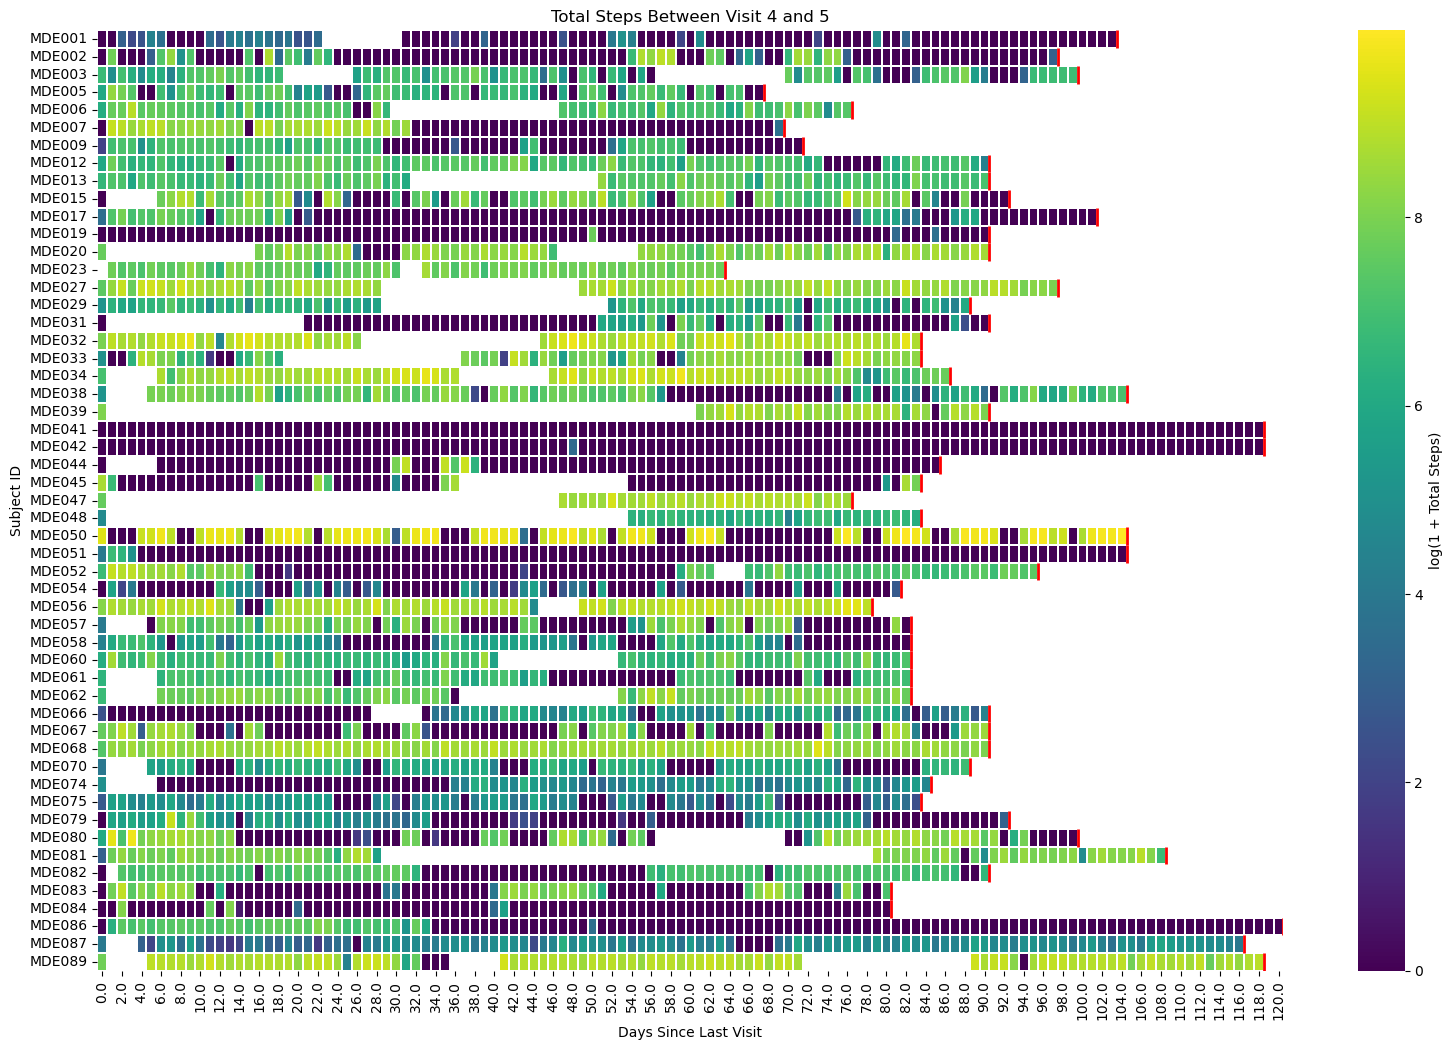

In [12]:
# Plot heatmap of total steps between visits
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

visit_ids = sorted(df_visit['visit_id'].unique())
for i in range(len(visit_ids) - 1):
    v_start = visit_ids[i]
    v_end = visit_ids[i + 1]
    # Get visit n and n+1 dates for each subject
    visit_n = df_visit[df_visit['visit_id'] == v_start][['subject_id', 'date']].rename(columns={'date': 'start_date'})
    visit_np1 = df_visit[df_visit['visit_id'] == v_end][['subject_id', 'date']].rename(columns={'date': 'end_date'})
    visit_window = visit_n.merge(visit_np1, on='subject_id', how='inner')
    # Filter measurements for this interval
    mask = df_measurement['subject_id'].isin(visit_window['subject_id'])
    filtered = df_measurement[mask].merge(visit_window, on='subject_id', how='left')
    filtered = filtered[(filtered['date'] > filtered['start_date']) & (filtered['date'] <= filtered['end_date'])]
    heatmap_data = filtered.pivot_table(index='subject_id', columns='days_since_last_visit', values='total_steps', aggfunc='sum')
    log_heatmap_data = np.log1p(heatmap_data)
    # Plot
    plt.figure(figsize=(16, max(6, 0.2*log_heatmap_data.shape[0])))
    ax = sns.heatmap(
        log_heatmap_data,
        cmap='viridis',
        cbar_kws={'label': 'log(1 + Total Steps)'},
        linewidths=0.1
    )
    plt.title(f'Total Steps Between Visit {v_start} and {v_end}')
    plt.xlabel('Days Since Last Visit')
    plt.ylabel('Subject ID')
    # Mark the next visit date for each subject
    for j, subject in enumerate(log_heatmap_data.index):
        subject_days = log_heatmap_data.columns[~log_heatmap_data.loc[subject].isna()]
        if len(subject_days) > 0:
            last_day = subject_days.max()
            col_idx = list(log_heatmap_data.columns).index(last_day)
            ax.vlines(col_idx + 1, j, j + 1, color='red', linewidth=2)
    plt.tight_layout()
    plt.show()

In [13]:
df_visit.query('subject_id == "MDE041"')

,subject_id,group,visit_id,ffp_status,ffp_score,date,ffp_status_binary,prev_visit_date,prev_ffp_status_binary,days_since_prev_visit
200,MDE041,exercise,1,0,3.0,2022-09-29,0,NaT,NaN,NaN
201,MDE041,exercise,2,1,2.0,2022-11-15,1,2022-09-29,0,47.0
202,MDE041,exercise,3,1,2.0,2023-01-04,1,2022-11-15,1,50.0
203,MDE041,exercise,4,1,2.0,2023-02-01,1,2023-01-04,1,28.0
204,MDE041,exercise,5,0,3.0,2023-05-31,0,2023-02-01,1,119.0


### Build features

In [23]:
ml_features = []
visit_ids = sorted(df_visit['visit_id'].unique())
for i in range(len(visit_ids) - 1):
    v_start = visit_ids[i]
    v_end = visit_ids[i + 1]
    # Get visit n and n+1 dates and frailty status for each subject
    visit_n = df_visit[df_visit['visit_id'] == v_start][['subject_id', 'date', 'ffp_status']].rename(
        columns={'date': 'start_date', 'ffp_status': 'prev_ffp_status'})
    visit_np1 = df_visit[df_visit['visit_id'] == v_end][['subject_id', 'date', 'ffp_status']].rename(
        columns={'date': 'measurement_date', 'ffp_status': 'target_ffp_status'})
    visit_window = visit_n.merge(visit_np1, on='subject_id', how='inner')
    # Filter measurements for this interval
    mask = df_measurement['subject_id'].isin(visit_window['subject_id'])
    filtered = df_measurement[mask].merge(visit_window, on='subject_id', how='left')
    filtered = filtered[(filtered['date'] > filtered['start_date']) & (filtered['date'] <= filtered['measurement_date'])]
    # Aggregate features for each subject-interval
    def longest_active_streak(steps):
        streak = max_streak = 0
        for s in steps:
            if s > 0:
                streak += 1
                max_streak = max(max_streak, streak)
            else:
                streak = 0
        return max_streak
    grouped = filtered.groupby(['subject_id', 'measurement_date', 'target_ffp_status', 'prev_ffp_status'])['total_steps']
    features = grouped.agg(
        total_steps_sum='sum',
        total_steps_mean='mean',
        total_steps_std='std',
        days_exercised=lambda x: (x > 0).sum(),
        interval_length='count',
        longest_active_streak=longest_active_streak
    ).reset_index()
    features['prop_days_exercised'] = features['days_exercised'] / features['interval_length']
    features['visit_interval'] = f'{v_start}_to_{v_end}'
    ml_features.append(features)

ml_feature_matrix = pd.concat(ml_features, ignore_index=True)
ml_feature_matrix = ml_feature_matrix.merge(df_subject, on='subject_id', how='left') # add subject features
ml_feature_matrix.head()

,subject_id,measurement_date,target_ffp_status,prev_ffp_status,total_steps_sum,total_steps_mean,total_steps_std,days_exercised,interval_length,longest_active_streak,prop_days_exercised,visit_interval,group,sex,age,ethnicity,race,monthly_income,education,marital_status,living_situation
0,MDE001,2021-08-23,frail,frail,211.0,6.028571,21.877313,8,35,2,0.228571,1_to_2,control,m,83.0,non_hisp,black,3000.0,18.0,never_married,with_others
1,MDE002,2021-08-30,no_frail,no_frail,0.0,0.000000,0.000000,0,40,0,0.000000,1_to_2,exercise,m,61.0,non_hisp,white,1033.0,3.0,never_married,alone
2,MDE003,2021-08-30,frail,no_frail,39007.0,1218.968750,599.782675,30,32,20,0.937500,1_to_2,exercise,f,69.0,hisp,white,1349.0,13.0,widowed,with_family
3,MDE004,2021-09-22,frail,frail,3720.0,128.275862,86.252493,29,29,29,1.000000,1_to_2,control,f,65.0,non_hisp,black,900.0,11.0,widowed,with_family
4,MDE005,2021-10-18,no_frail,frail,39530.0,1275.161290,1083.488843,27,31,16,0.870968,1_to_2,control,f,84.0,non_hisp,black,792.0,3.0,widowed,with_family


In [48]:
weird_not_worn_but_steps = df_measurement[
    ((df_measurement['total_minutes_wear_time'] == 0) | (df_measurement['percentage_wear_time'] == 0)) &
    (df_measurement['total_steps'] > 0)
]
print("Days not worn but steps recorded:", len(weird_not_worn_but_steps))

Days not worn but steps recorded: 3581


In [49]:
weird_steps_no_distance = df_measurement[
    (df_measurement['total_steps'] > 0) &
    ((df_measurement['total_distance'] == 0) | (df_measurement['tracker_distance'] == 0))
]
print("Days with steps but no distance:", len(weird_steps_no_distance))

Days with steps but no distance: 99


In [19]:
weird_steps_no_calories = df_measurement[
    (df_measurement['total_steps'] > 0) &
    (df_measurement['calories'] == 0)
]
print("Days with steps but no calories:", len(weird_steps_no_calories))

Days with steps but no calories: 0


In [53]:
df_measurement.isna().sum().sort_values(ascending=False)

floors                        14271
max_sp_o2                     13111
min_sp_o2                     13111
average_sp_o2                 13111
resting_heart_rate             9786
date                              0
marginal_calories                 0
calories_bmr                      0
calories                          0
sedentary_minutes                 0
lightly_active_minutes            0
fairly_active_minutes             0
subject_id                        0
sedentary_active_distance         0
light_active_distance             0
moderately_active_distance        0
very_active_distance              0
logged_activities_distance        0
tracker_distance                  0
total_distance                    0
total_steps                       0
percentage_wear_time              0
total_minutes_wear_time           0
very_active_minutes               0
dtype: int64